# TRex Benchmark on simulated data

In [1]:
suppressPackageStartupMessages({
  library(dplyr)
  library(binr)
  library(RColorBrewer)
  library(cowplot) 
  library(data.table)
  library(ggpubr)
  library(SummarizedExperiment)
  library(ggplot2)
  library(viridis)
  library(grid)
  library(gridExtra)
  library(patchwork)
  library(ggpubr)
  library(ggsci)
  library(caret)
  library(precrec)
  library(caret)
  library(parallel)
  library(plotROC)
})

### Functions

In [2]:
anot_level<-function(mat,method){
  
  anots<-data.frame(method=rep(method,length(rownames(mat))),row.names = rownames(mat))
  
  anots$I_detected_isoforms<-lapply(strsplit(mat$inclusion,";"),length)%>%unlist()
  anots$S_detected_isoforms<-lapply(strsplit(mat$skipping,";"),length)%>%unlist()

  anots[anots$I_detected_isoforms>=1 & anots$S_detected_isoforms>=1,"annot_category"]<-"both annotated"
  anots[anots$I_detected_isoforms==0 & anots$S_detected_isoforms>=1,"annot_category"]<-"no inclusion"
  anots[anots$I_detected_isoforms>=1 & anots$S_detected_isoforms==0,"annot_category"]<-"no skipping"
  anots[anots$I_detected_isoforms==0 & anots$S_detected_isoforms==0,"annot_category"]<-"none annotated"
  
  anots$annot_category<-factor(anots$annot_category,levels=c("no inclusion","no skipping","none annotated","both annotated"))
  return(anots)
}

### Load data

In [26]:
ref <- read.table(file="../input/ground_truth_PSI.tsv")
sim_dir <- "../output"
fig_dir <- "../output/figures"

In [ ]:
runs <- list.dirs(sim_dir,recursive = FALSE,full.names = FALSE)

In [ ]:
ref<-ref[rowSums(ref[,1:4])>4, ] # Remove events with very low counts
ref<-ref[!(is.na(ref$log_dPSI_SRSF9.KD_vs_control)|is.infinite(ref$log_dPSI_SRSF9.KD_vs_control)), ] # Remove entries with 0 PSI 
ref$event_name<-rownames(ref)

In [ ]:
trex_nb <- lapply(runs,function(run,...){
    
            trex<-read.table(file = file.path(sim_dir,run,"trex_nobatch/trex.PSI.tsv"),header = T) %>%
                  as_tibble(rownames = "event_name") %>%
                  filter(!is.na(glm_log2FoldChange)) %>%
                  mutate(run_par = run)
            return(trex) 

        }) %>%
        do.call(rbind,.)

trex <- lapply(runs,function(run,...){
    
            trex<-read.table(file = file.path(sim_dir,run,"trex/trex.PSI.tsv"),header = T) %>%
                  as_tibble(rownames = "event_name") %>%
                  filter(!is.na(glm_log2FoldChange)) %>%
                  mutate(run_par = run)
            return(trex) 

        }) %>%
        do.call(rbind,.)

RMATS <- lapply(runs,function(run,...){
            RMATS<-read.csv(file = file.path(sim_dir,run,"RMATS/SE.MATS.JC.SUPPA2.trex.tsv"),header = T,row.names = 1) %>%
                   as_tibble(rownames = NA)%>%
                   filter(!is.na(IncLevelDifference)) %>%
                   mutate(run_par = run)
            return(RMATS)
    }) %>%
    do.call(rbind,.)

suppa <- lapply(runs,function(run,...){
            suppa<-read.table(file = file.path(sim_dir,run,"SUPPA2/SE.events.dpsi"),header = T) %>%
                        as_tibble(rownames = "SUPPA2_ID") %>%
                        filter(!is.na(K562_control.K562_SRSF9_KD_dPSI)) %>%
                        mutate(run_par = run)
            return(suppa)
          }) %>%
          do.call(rbind,.)

### Map identifiers across methods

In [ ]:
cords_suppa <- strsplit(unique(suppa$SUPPA2_ID),":|-|;") %>%
                as.data.frame() %>% t() %>% as_tibble()
colnames(cords_suppa)<-c("GeneID","ASevent","chr","upstreamEE","exonStart_0base","exonEnd","downstreamES","strand")
cords_suppa <- cords_suppa %>%
                mutate(SUPPA2_ID=unique(suppa$SUPPA2_ID),
                       upstreamEE=as.numeric(upstreamEE),
                       exonStart_0base=as.numeric(exonStart_0base)-1,
                       exonEnd=as.numeric(exonEnd),
                       downstreamES=as.numeric(downstreamES)-1) %>%
                mutate(strand=substr(SUPPA2_ID, nchar(SUPPA2_ID), nchar(SUPPA2_ID)))

In [ ]:
cords_trex <- strsplit(unique(paste(trex$GeneID,trex$event_name,sep=";")),":|-|;") %>%
                as.data.frame() %>% t() %>% as_tibble()
colnames(cords_trex)<-c("GeneID","ASevent","chr","upstreamES","upstreamEE","exonStart_0base","exonEnd","downstreamES","downstreamEE","strand")
cords_trex <- cords_trex %>%
                mutate(across(upstreamES:downstreamES,as.numeric)) %>%
                mutate(event_name=unique(trex$event_name)) %>%
                mutate(strand=substr(event_name, nchar(event_name), nchar(event_name))) %>%
                left_join(trex %>% distinct(event_name,inclusion,skipping),by = "event_name")

In [ ]:
cords_map<-inner_join(cords_suppa,cords_trex,
                      by = c("GeneID", "ASevent", "chr", "upstreamEE", "exonStart_0base","exonEnd", "downstreamES", "strand")) %>%
           mutate(annot_category=anot_level(.,method = "SUPPA2")$annot_category)

In [ ]:
head(cords_map)

### Process data for benchmarking

#### Predictions

In [ ]:
TRex.bm <- trex %>%
               select(GeneID, event_name, run_par, glm_log2FoldChange,glm_pvalue) %>%
               rename("glm_log2FoldChange"="log_dPSI") %>%
               mutate(dPSI=NA,
                      method="TRex.baseline",
                      signif = p.adjust(glm_pvalue,method = "fdr")) %>%
               select(-glm_pvalue)

TRex.baseline.bm <- trex_nb %>%
                   select(GeneID, event_name, run_par, glm_log2FoldChange,glm_pvalue) %>%
                   rename("glm_log2FoldChange"="log_dPSI") %>%
                   mutate(dPSI=NA,
                          method="TRex.baseline",
                          signif = p.adjust(glm_pvalue,method = "fdr")) %>%
                   select(-glm_pvalue)

RMATS.bm <- RMATS %>%
            select(GeneID,event_name,run_par,IncLevelDifference,FDR) %>%
            mutate(dPSI=IncLevelDifference*-1,
                   log_dPSI = NA,
                   method="RMATS")%>%
            select(-IncLevelDifference) %>%
            rename("FDR"="signif")

suppa.bm <- inner_join(suppa,cords_map %>% select(GeneID,event_name,SUPPA2_ID),by="SUPPA2_ID") %>%
            rename("K562_control.K562_SRSF9_KD_dPSI"="dPSI") %>%
            mutate(signif=p.adjust(K562_control.K562_SRSF9_KD_p.val,method = "fdr")) %>%
            select(GeneID,event_name,run_par,dPSI,signif) %>%
            mutate(log_dPSI = NA,
                   method = "SUPPA2")

In [ ]:
bm.data <- rbind(TRex.bm,TRex.baseline.bm,RMATS.bm,suppa.bm) %>%
           mutate(batch_effect = sub("run_","",run_par) %>% sub("_rs.*","",.) %>% as.numeric(),
                  run_number = sub("run.*_rs\\.","",run_par) %>% as.numeric(),
                  pred_score = -1*log(signif+0.000001)) %>%
           select(-run_par) %>%
           group_by(method, batch_effect, run_number) %>%
           tidyr::nest()

#### Reference

In [ ]:
get_class_labels<-function(dpsi,dlog,...){
    ref <- ref.bm %>%
            mutate(class_labels = ifelse( abs(ref_dPSI)>=dpsi & abs(ref_log_dPSI)>=dlog ,1,0)) %>%
            mutate(num_pos = sum(class_labels==1),
                   num_neg = sum(class_labels==0),
                   dPSI_th = dpsi,
                   dLogitPSI_th = dlog)
    return(ref)
}

In [ ]:
ref.bm <- ref %>%
          select(event_name,dPSI_SRSF9.KD_vs_control,log_dPSI_SRSF9.KD_vs_control) %>%
          rename("dPSI_SRSF9.KD_vs_control"="ref_dPSI","log_dPSI_SRSF9.KD_vs_control"="ref_log_dPSI")

In [ ]:
dPSI_th<-seq(0,0.95,0.05)
dLogitPSI_th<-seq(0,4.75,0.25)
ref.bm.labels <- tidyr::crossing(dPSI_th,dLogitPSI_th) %>%
                 group_by(dPSI_th,dLogitPSI_th) %>% 
                 mutate(data = purrr::map2(.f = get_class_labels,.x=dPSI_th,.y=dLogitPSI_th)) %>%
                 as_tibble()

### Compute performance metrics

In [ ]:
compute_auroc<-function(ref.data,preds.data){
    
    # Extract data frames

    preds.data <- inner_join(preds.data,ref.data,by="event_name") 
    if(unique(preds.data$num_neg)>=10 & unique(preds.data$num_pos>=10) & sum(is.na(preds.data$num_pos))!= nrow(preds.data)){

        auc<-evalmod(scores = preds.data$pred_score, 
                     labels = preds.data$class_labels,
                     modnames = 'auc',
                     mode = "aucroc")    
    }else{
        auc<-list(uaucs=data.frame('modnames'= 'auc',
                                 'dsids'= NA,
                                 'aucs'= NA,
                                 'ustats'= NA))
    }
    
    auc.df <- auc$uaucs %>%
              as_tibble() %>%
              mutate(num_pos = unique(preds.data$num_pos),
                     num_neg = unique(preds.data$num_neg),
                     num_events = num_pos + num_neg,
                     evalmod_out = list(auc))

    return(auc.df)
}

auroc_wrapper<-function(row.data,...){
    
    row.perf <- ref.bm.labels %>%
                mutate(performace=purrr::map(.x=data,.f=compute_auroc,preds.data=row.data)) %>%      
                select(-data) %>%
                tidyr::unnest(c(performace)) 
    #message(paste("Calculated for thresholds =",unique(row.perf$dPSI_th),unique(row.perf$dLogitPSI_th),"\n"))
    return(row.perf)

}

In [ ]:
perf.data <- bm.data %>% 
             group_by(method,batch_effect,run_number) %>% 
             mutate(perf_list = mclapply(data,auroc_wrapper,ref.bm.labels,mc.cores = 4)) %>% 
             select(-data)%>% 
             tidyr::unnest(c(perf_list))

In [ ]:
saveRDS(perf.data,file = "../output/performance_metrics.RDS")

In [ ]:
dim(perf.data)

## Visualize results

In [18]:
perf.data<-readRDS(file = "../output/performance_metrics.RDS")

In [19]:
heatmap_theme<-list(
    theme_pubr(),
    theme(panel.border=element_blank(),
        plot.title = element_text(size = 20,face='bold',hjust = 0.5),
        panel.grid.major = element_blank(), 
        panel.grid = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(), 
        legend.position ="right",
        legend.title.align = 0,
        legend.title = element_text(size=14,face='bold'),
        legend.text = element_text(size=12),
        strip.background = element_rect(fill = "white",color = "white",linewidth = 1),
        strip.text = element_text(size=14,face="italic"),
        axis.text.x = element_text(angle=90,vjust=0.5),
        axis.title = element_text(face="bold",size=14),
        axis.line = element_blank()),
    scale_x_continuous(limits = c(0,0.5), breaks = c(0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45) , expand = c(-0.01, -0.01)),
    scale_y_continuous(limits = c(0,3), breaks = c(0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75),expand = c(-0.01, -0.01))
)


In [20]:
col.pal <- colorRampPalette(brewer.pal(11,"Spectral"))

In [21]:
head(perf.data)

method,batch_effect,run_number,dPSI_th,dLogitPSI_th,n_pos,n_neg,modnames,dsids,aucs,ustats,num_pos,num_neg,num_events,cor_dPSI,cor_dLogitPSI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<fct>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
TRex,0,1,0,0.00,17246,0,auc,NA,NA,NA,17229,0,17229,0.6941336,0.7881135
TRex,0,1,0,0.25,9174,8072,auc,1,0.7490409,55468369,9164,8065,17229,0.7505334,0.8534707
TRex,0,1,0,0.50,4522,12724,auc,1,0.7836784,45091234,4516,12713,17229,0.7798937,0.8911782
TRex,0,1,0,0.75,2179,15067,auc,1,0.8229963,27019787,2176,15053,17229,0.7930985,0.9133724
TRex,0,1,0,1.00,1124,16122,auc,1,0.8443645,15300837,1123,16106,17229,0.8033425,0.9306616
TRex,0,1,0,1.25,524,16722,auc,1,0.8602204,7537533,524,16705,17229,0.8126323,0.9464382


In [22]:
perf.data.filt <- perf.data %>%
                  filter(dLogitPSI_th<3 & dPSI_th<0.5)

In [23]:
perf.data.mean <- perf.data.filt %>%
                    group_by(method,batch_effect,dPSI_th,dLogitPSI_th) %>%
                    summarize(aucs_mean=mean(aucs),
                               n=n(),
                               se=sd(aucs)/sqrt(length((aucs))),
                               num_pos_mean=mean(num_pos),
                               num_neg_mean=mean(num_neg),
                               num_events_mean=mean(num_events)) %>%
                    mutate(bes=paste0("bes = ",batch_effect))

`summarise()` has grouped output by 'method', 'batch_effect', 'dPSI_th'. You
can override using the `.groups` argument.


### Peformance per method

Warning message:
“Removed 105 rows containing missing values (`geom_tile()`).”
Warning message:
“Removed 105 rows containing missing values (`geom_tile()`).”


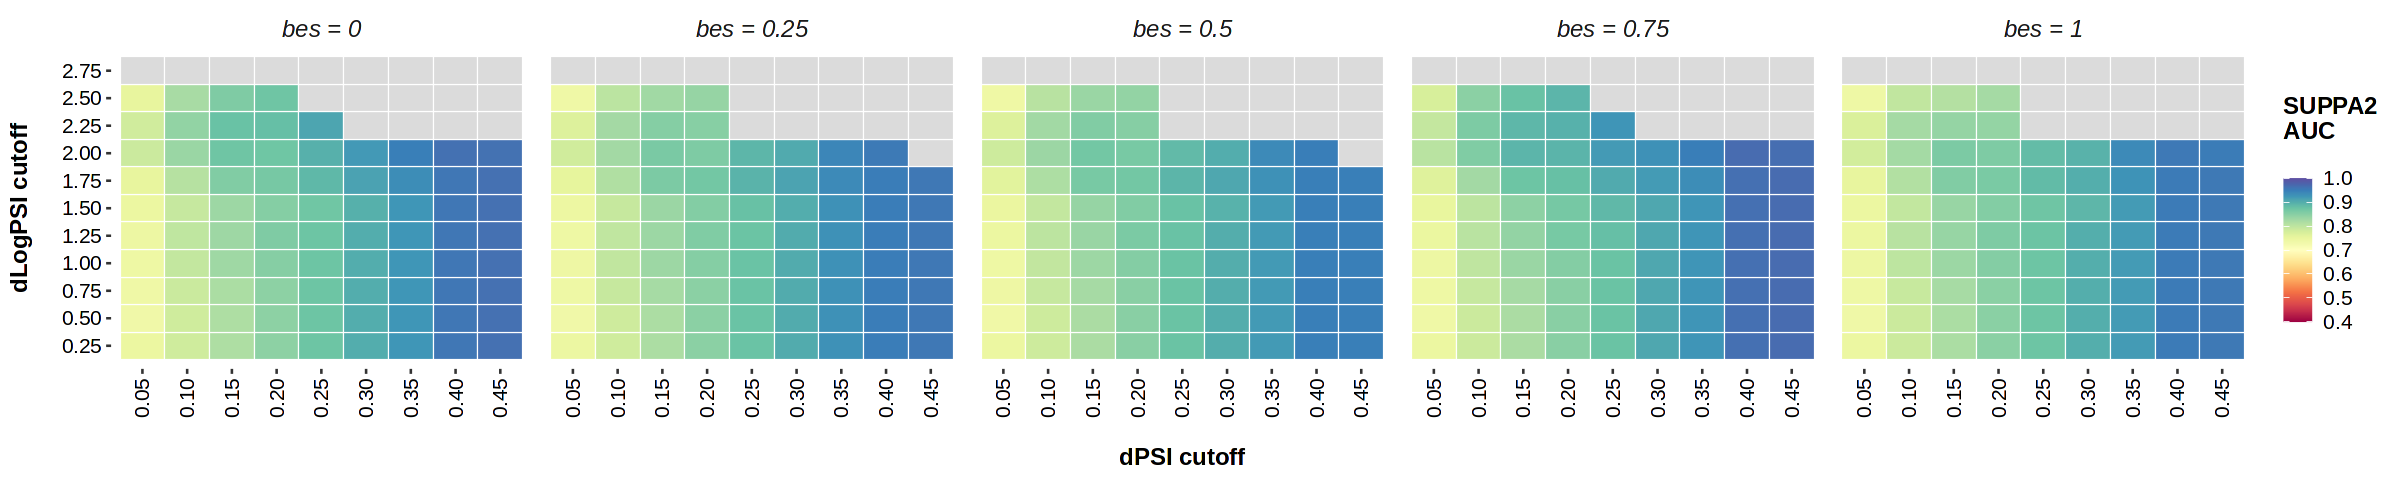

In [28]:
options(repr.plot.width=20, repr.plot.height=4)
m<-"SUPPA2"
p<-perf.data.mean %>%
    filter(method==m)%>%
    ggplot(.,aes(x=dPSI_th,y=dLogitPSI_th,fill=aucs_mean))+
        geom_tile(colour="white",size=0.25)+ 
        facet_wrap(~bes,ncol=5)+
        heatmap_theme+
        scale_fill_gradientn(colours = col.pal(25), limits=c(0.4,1.0),na.value = "grey86")+
        labs(fill=paste(toupper(m),"\nAUC\n"),x="\ndPSI cutoff",y="dLogPSI cutoff\n")

ggsave(p,file=file.path(fig_dir,"performance_SUPPA2.png"),width = 20,height = 4)
p

Warning message:
“Removed 105 rows containing missing values (`geom_tile()`).”
Warning message:
“Removed 105 rows containing missing values (`geom_tile()`).”


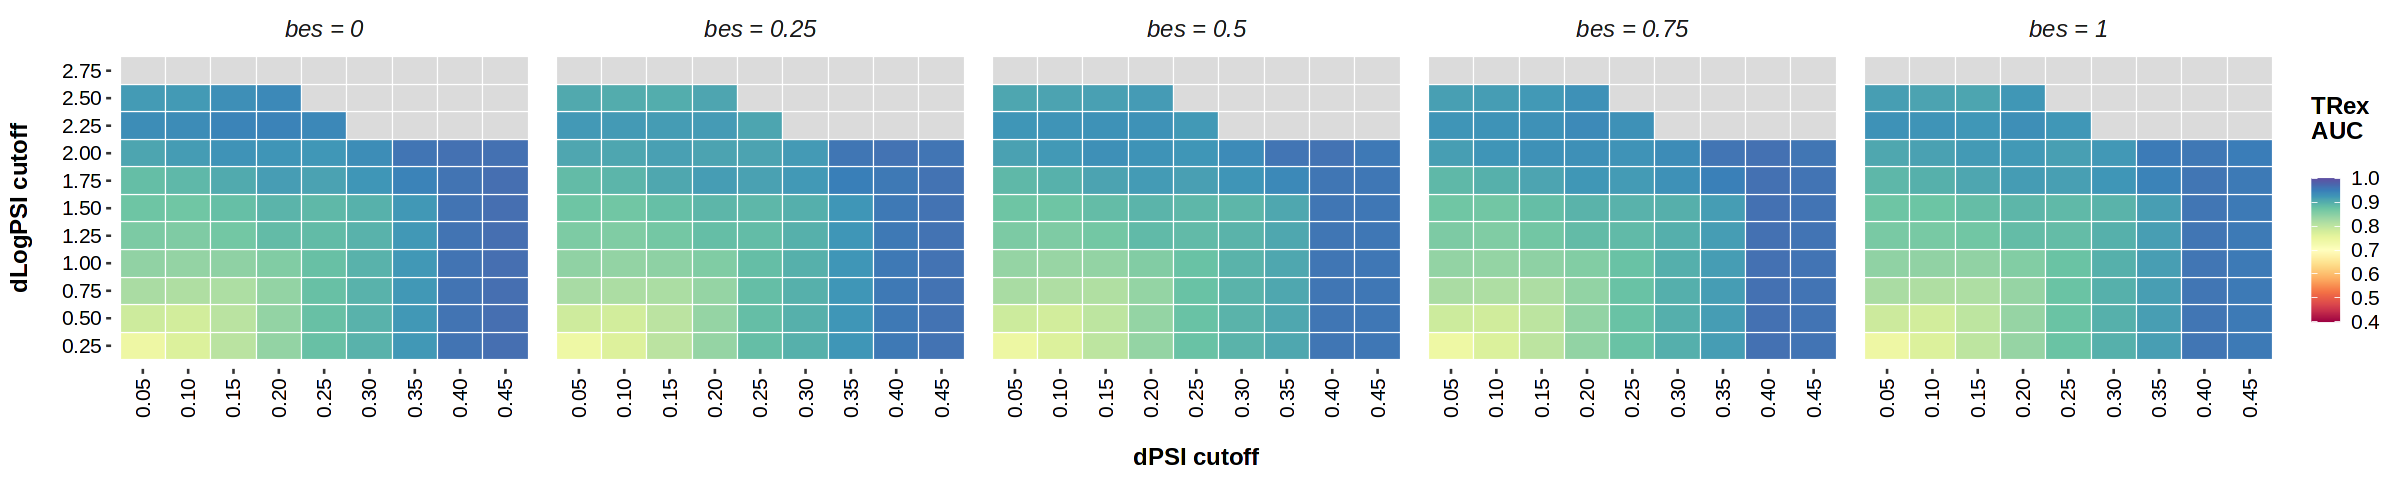

In [29]:
options(repr.plot.width=20, repr.plot.height=4)
m<-"TRex"
p<-perf.data.mean %>%
    filter(method==m)%>%
    ggplot(.,aes(x=dPSI_th,y=dLogitPSI_th,fill=aucs_mean))+
        geom_tile(colour="white",size=0.25)+ 
        facet_wrap(~bes,ncol=5)+
        heatmap_theme+
        scale_fill_gradientn(colours = col.pal(25), limits=c(0.4,1.0),na.value = "grey86")+
        labs(fill=paste("TRex","\nAUC\n"),x="\ndPSI cutoff",y="dLogPSI cutoff\n")
ggsave(p,file=file.path(fig_dir,"performance_TRex.png"),width = 20,height = 4)
p

Warning message:
“Removed 105 rows containing missing values (`geom_tile()`).”
Warning message:
“Removed 105 rows containing missing values (`geom_tile()`).”


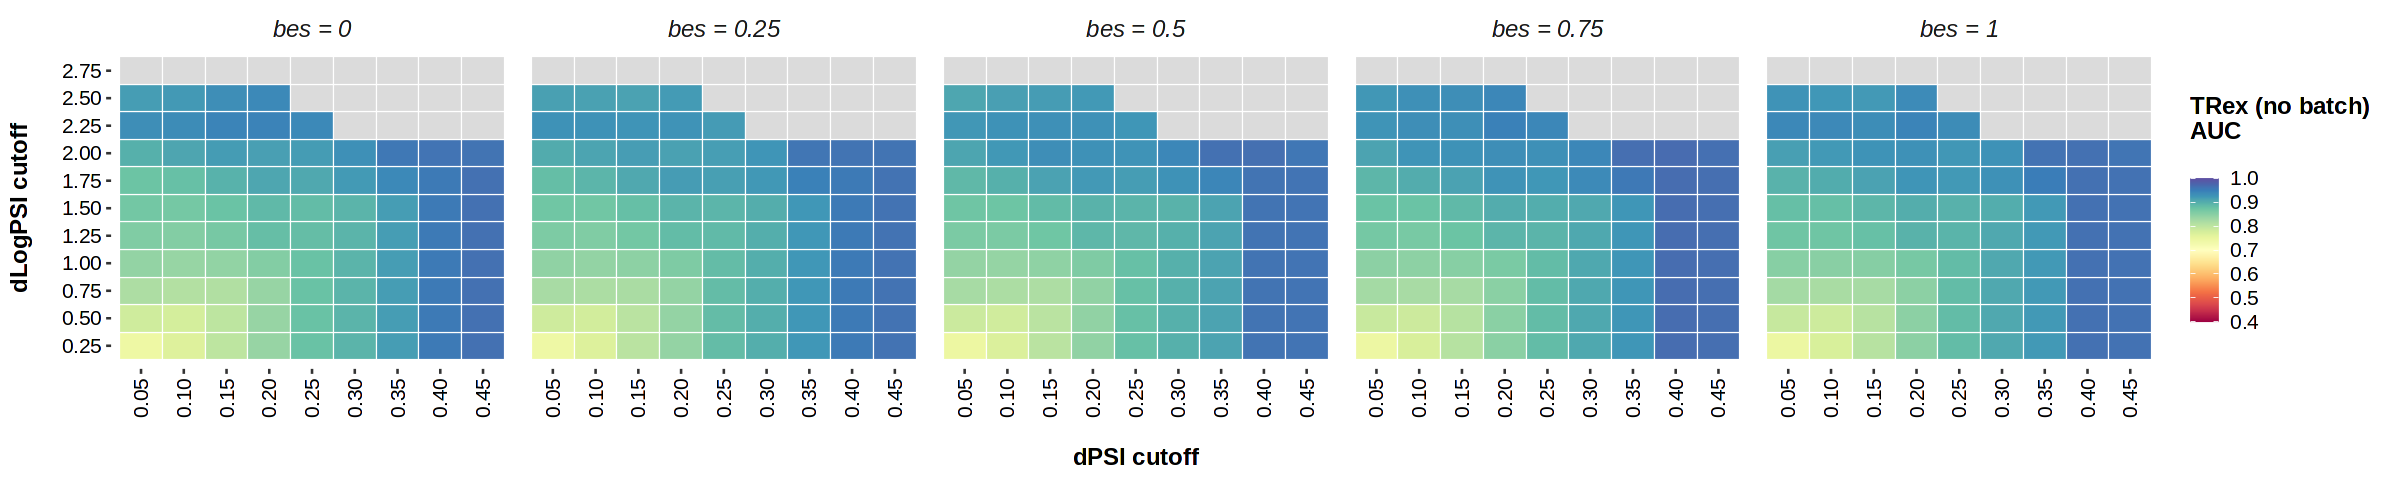

In [30]:
options(repr.plot.width=20, repr.plot.height=4)
m<-"TRex.baseline"
p<-perf.data.mean %>%
    filter(method==m)%>%
    ggplot(.,aes(x=dPSI_th,y=dLogitPSI_th,fill=aucs_mean))+
        geom_tile(colour="white",size=0.25)+ 
        facet_wrap(~bes,ncol=5)+
        heatmap_theme+
        scale_fill_gradientn(colours = col.pal(25), limits=c(0.4,1.0),na.value = "grey86")+
        labs(fill=paste("TRex (no batch)","\nAUC\n"),x="\ndPSI cutoff",y="dLogPSI cutoff\n")

ggsave(p,file=file.path(fig_dir,"performance_TRex.baseline.png"),width = 20,height = 4)
p

Warning message:
“Removed 105 rows containing missing values (`geom_tile()`).”
Warning message:
“Removed 105 rows containing missing values (`geom_tile()`).”


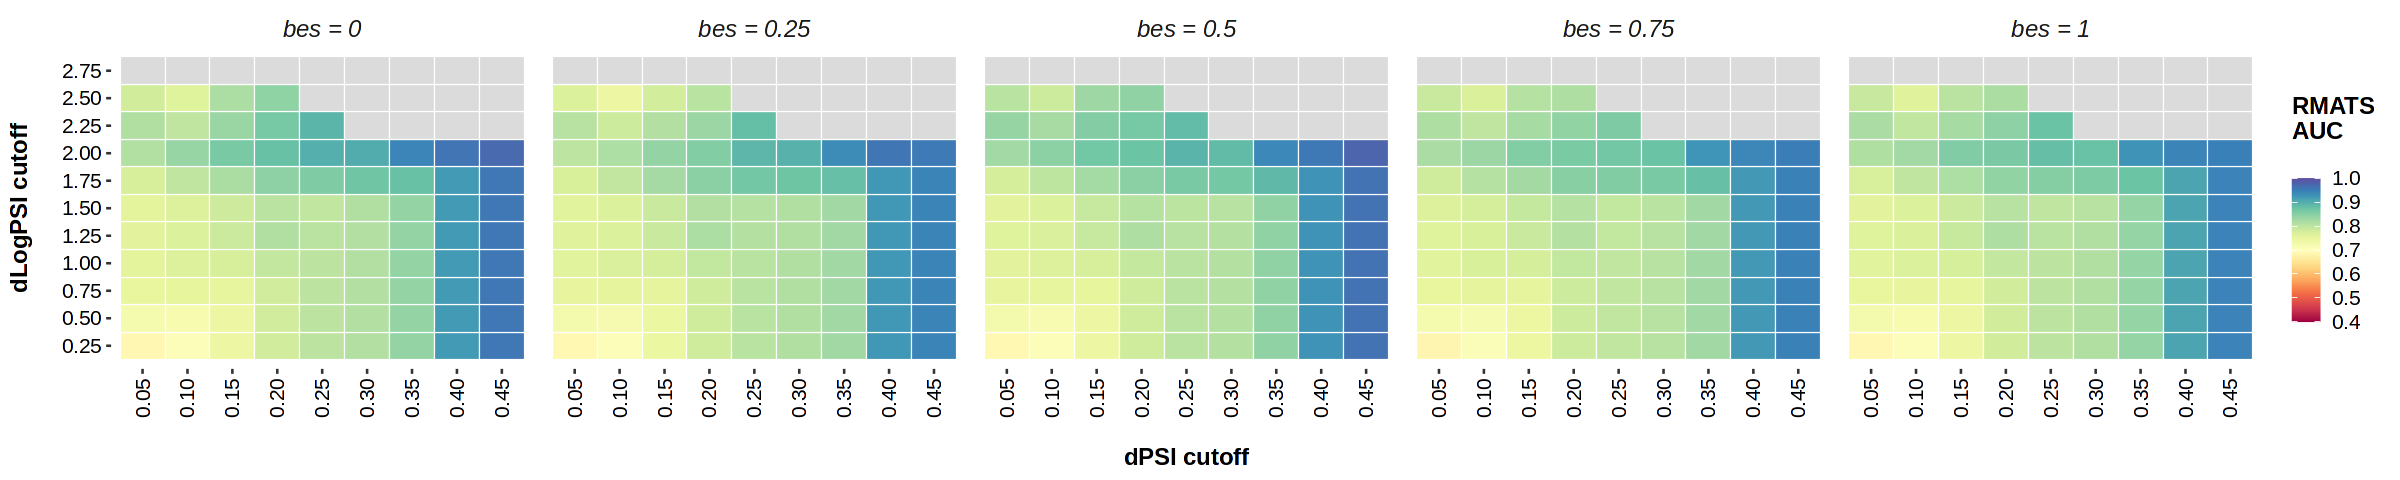

In [33]:
options(repr.plot.width=20, repr.plot.height=4)
m<-"rMATS"
p<-perf.data.mean %>%
    filter(method==m) %>%
    ggplot(.,aes(x=dPSI_th,y=dLogitPSI_th,fill=aucs_mean))+
        geom_tile(colour="white",size=0.25)+ 
        facet_wrap(~bes,ncol=5)+
        heatmap_theme+
        scale_fill_gradientn(colours = col.pal(25), limits=c(0.4,1.0),na.value = "grey86")+
        labs(fill=paste("RMATS","\nAUC\n"),x="\ndPSI cutoff",y="dLogPSI cutoff\n")

ggsave(p,file=file.path(fig_dir,"performance_RMATS.png"),width = 20,height = 4)
p

### Trex diferential

In [36]:
trex.perf <- perf.data.mean %>%
             filter(method=="TRex") %>%
             ungroup() %>%
             select(-method)
colnames(trex.perf)[4:ncol(trex.perf)]<-paste("trex.",colnames(trex.perf)[4:ncol(trex.perf)],sep="")

In [45]:
suppa.perf <- perf.data.mean %>%
              filter(method=="SUPPA2") %>%
              left_join(.,trex.perf) %>%
              mutate(dif_auc=trex.aucs_mean-aucs_mean) %>%
              filter(batch_effect%in%c(0,1)) %>%
              mutate(batch_effect=paste0("bes = ",batch_effect))
              

RMATS.perf <- perf.data.mean %>%
              filter(method=="rMATS") %>%
              left_join(.,trex.perf) %>%
              mutate(dif_auc=trex.aucs_mean-aucs_mean) %>%
              filter(batch_effect%in%c(0,1))%>%
              mutate(batch_effect=paste0("bes = ",batch_effect))

trex_nb.perf <- perf.data.mean %>%
                  filter(method=="TRex.baseline") %>%
                  left_join(.,trex.perf) %>%
                  mutate(dif_auc=trex.aucs_mean-aucs_mean) %>%
                  filter(batch_effect%in%c(0,1))%>%
                  mutate(batch_effect=paste0("bes = ",batch_effect))

Joining, by = c("batch_effect", "dPSI_th", "dLogitPSI_th")
Joining, by = c("batch_effect", "dPSI_th", "dLogitPSI_th")
Joining, by = c("batch_effect", "dPSI_th", "dLogitPSI_th")


In [38]:
col.pal <- colorRampPalette(colors = c("#FF0000","#FFFFFF","#0000FF"))

Warning message:
“Removed 42 rows containing missing values (`geom_tile()`).”
Warning message:
“Removed 42 rows containing missing values (`geom_tile()`).”


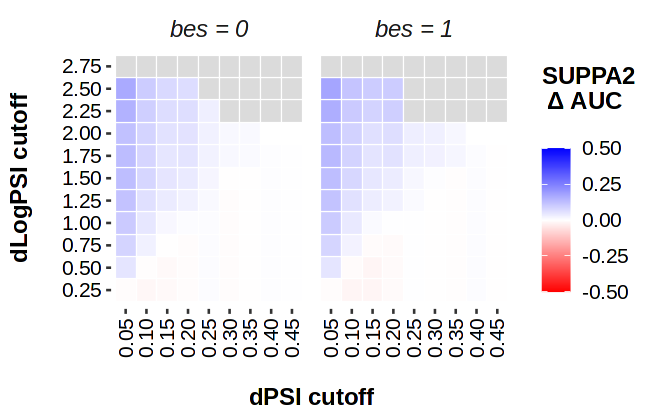

In [40]:
options(repr.plot.width=5.5, repr.plot.height=3.5)
p<-ggplot(suppa.perf,aes(x=dPSI_th,y=dLogitPSI_th,fill=dif_auc))+
    geom_tile(colour="white",size=0.25)+ 
    facet_wrap(~batch_effect,ncol=2)+
    labs(fill="SUPPA2\n \u0394 AUC   \n", x="\ndPSI cutoff",y="dLogPSI cutoff\n")+
    heatmap_theme+
    scale_fill_gradientn(colours = col.pal(25), limits=c(-0.5, 0.5),na.value = "grey86")
ggsave(p,file=file.path(fig_dir,"differential_performance_TRex_vs_SUPPA2.png"),width = 5.5,height = 3.5)
p

Warning message:
“Removed 42 rows containing missing values (`geom_tile()`).”
Warning message:
“Removed 42 rows containing missing values (`geom_tile()`).”


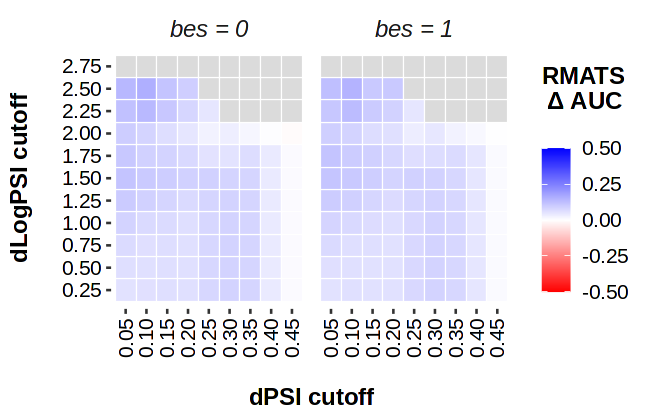

In [47]:
options(repr.plot.width=5.5, repr.plot.height=3.5)
p<-ggplot(RMATS.perf,aes(x=dPSI_th,y=dLogitPSI_th,fill=dif_auc))+
    geom_tile(colour="white",size=0.25)+ 
    facet_wrap(~batch_effect,ncol=5)+
    labs(fill="RMATS\n \u0394 AUC   \n", x="\ndPSI cutoff",y="dLogPSI cutoff\n")+
    heatmap_theme+
    scale_fill_gradientn(colours = col.pal(25), limits=c(-0.5, 0.5),na.value = "grey86")
ggsave(p,file=file.path(fig_dir,"differential_performance_TRex_vs_RMATS.png"),width = 5.5,height = 3.5)
p

#### Summary statistics

In [57]:
max(suppa.perf$dif_auc,na.rm=T)

[1] 0.1768337

In [56]:
max(c(RMATS.perf$dif_auc),na.rm=T)

[1] 0.1563976